In [1]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 12210
-rw------- 1 root root 6428389 May 28 10:08 '03 Result Data Cleaning Part 3.csv'
-rw------- 1 root root 5535519 May 28 10:12  04a_ARIMA_Katulampa.ipynb
-rw------- 1 root root  526138 May 28 10:08  04e_ARIMA_Pasar_Ikan.ipynb
-rw------- 1 root root   12122 May 28 10:08  LibrariesFunctions.py


In [2]:
# Import libraries and functions
%run LibrariesFunctions.py
from LibrariesFunctions import *

# Import Data

In [3]:
data_x_train, data_x_test, data_y_train, data_y_test = read_data('Katulampa')

Full Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31224 entries, 2021-10-16 00:00:00 to 2025-05-08 23:00:00
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_Raw                31196 non-null  float64
 1   ID_Cleaned            31224 non-null  int64  
 2   Katulampa (air)       31224 non-null  float64
 3   Katulampa (cuaca)     31224 non-null  object 
 4   Depok (air)           31224 non-null  float64
 5   Depok (cuaca)         31224 non-null  object 
 6   Manggarai (air)       31224 non-null  float64
 7   Manggarai (cuaca)     31224 non-null  object 
 8   Karet (air)           31224 non-null  float64
 9   Karet (cuaca)         31224 non-null  object 
 10  Krukut (air)          31224 non-null  float64
 11  Krukut (cuaca)        31224 non-null  object 
 12  Pesanggrahan (air)    31224 non-null  float64
 13  Pesanggrahan (cuaca)  31224 non-null  object 
 14  Angke (ai

In [4]:
data_y_train

,Katulampa (air)
Tanggal,
2021-10-16 00:00:00,10.0
2021-10-16 01:00:00,10.0
2021-10-16 02:00:00,10.0
2021-10-16 03:00:00,10.0
2021-10-16 04:00:00,10.0
...,...
2025-03-04 17:00:00,70.0
2025-03-04 18:00:00,70.0
2025-03-04 19:00:00,60.0


# EDA

In [5]:
period = 24

decomposition = seasonal_decompose(
    data_y_train,
    model='additive',
    period=period,
    extrapolate_trend='freq'
)
plot_decompose(decomposition)

Output hidden; open in https://colab.research.google.com to view.

# Uji Stasioneritas

## Uji Stasioneritas terhadap Varians

$$
\begin{aligned}
H_0&: \lambda=1 \text{(Stasioner terhadap varians)}\\H_1&: \lambda\ne1\\
\end{aligned}
$$

In [6]:
lambda_opt = boxcox_transformation(data_y_train)

Lambda optimal: -1.3925
LRT statistic: 37668.5313
P-value: 0.000000


In [7]:
print(f"{lambda_opt:.50f}")

-1.39248036591364821035199383914005011320114135742188


Karena P-Value LR test lambda(1) = 0.000000 < 0.05, maka tolak H0, maka data tidak stasioner terhadap varians, sehingga perlu dilakukan transformasi sesuai dengan lambda optimal

In [8]:
data_y_train_pow = data_y_train ** lambda_opt
boxcox_transformation(data_y_train_pow)

Lambda optimal: 1.0000
LRT statistic: 0.0000
P-value: 0.999996


np.float64(0.9999999795043365)

## Uji Stasioneritas terhadap Mean

$$
\begin{aligned}
H_0&: \text{Data tidak stasioner terhadap mean}\\
H_1&: \text{Data stasioner terhadap mean}\\
\end{aligned}
$$

In [9]:
result = adfuller(data_y_train_pow)

# Hasil ADF test
print(f"ADF Statistic : {result[0]}")
print(f"p-value       : {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {value}")

ADF Statistic : -8.098528274190905
p-value       : 1.3189154107984117e-12
Critical Values:
   1% : -3.4305708593757225
   5% : -2.86163761382706
   10% : -2.5668219568695214


# ACF PACF

Karena p-value 1.275e-18 =  < 0.05, maka tolak H0, sehingga kita memiliki cukup bukti untuk menyimpulkan bahwa data stasioner terhadap mean

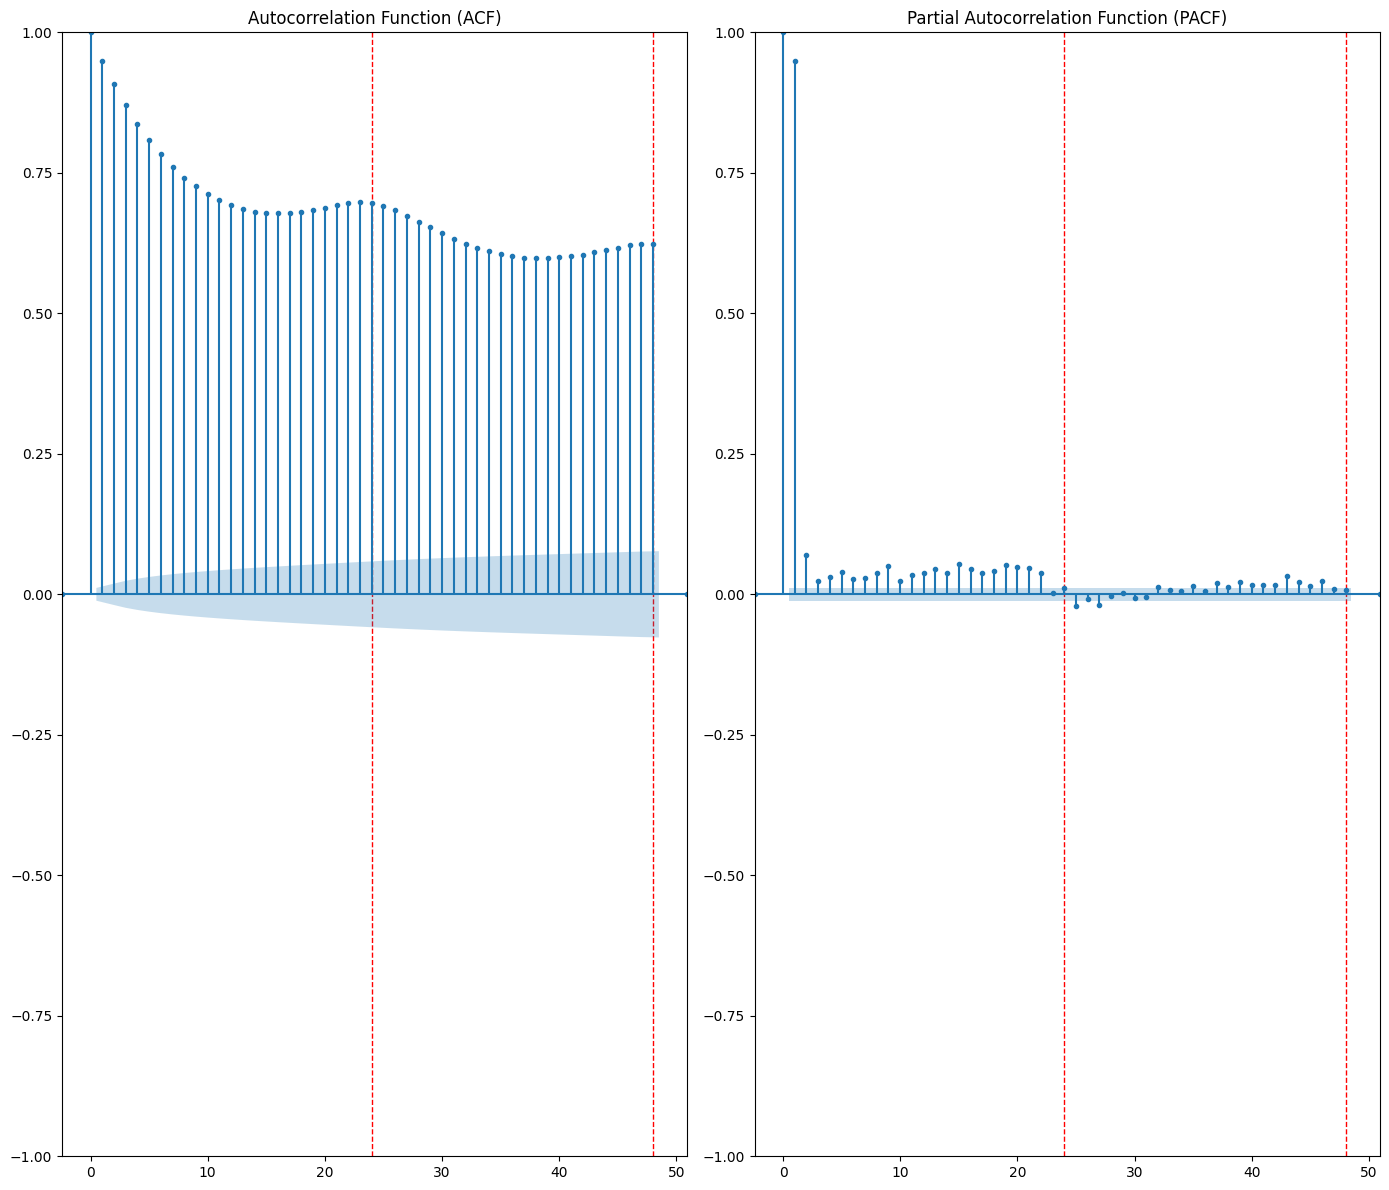

In [10]:
plot_acf_pacf(data_y_train_pow, period, 48)

# Modelling

In [11]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-22)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(8,0,0)', 'model_type': 'ARIMA', 'order': (8,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(9,0,0)', 'model_type': 'ARIMA', 'order': (9,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(10,0,0)', 'model_type': 'ARIMA', 'order': (10,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(11,0,0)', 'model_type': 'ARIMA', 'order': (11,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(12,0,0)', 'model_type': 'ARIMA', 'order': (12,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(13,0,0)', 'model_type': 'ARIMA', 'order': (13,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(14,0,0)', 'model_type': 'ARIMA', 'order': (14,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(15,0,0)', 'model_type': 'ARIMA', 'order': (15,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(16,0,0)', 'model_type': 'ARIMA', 'order': (16,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(17,0,0)', 'model_type': 'ARIMA', 'order': (17,0,0), 'seasonal_order': None, 'exog': False},
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood              117913.558
Date:                Wed, 28 May 2025   AIC                        -235821.117
Time:                        10:16:35   BIC                        -235796.224
Sample:                    10-16-2021   HQIC                       -235813.125
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.001     44.263      0.000       0.027       0.030
ar.L1          0.9495      0.005    175.635      0.000       0.93

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Katulampa (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,6.0644,14.3387
1,Katulampa (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,6.1930,14.2829
2,Katulampa (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,6.2423,14.2621
3,Katulampa (air),"ARIMA(4,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,6.2769,14.2329
4,Katulampa (air),"ARIMA(5,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,6.2999,14.1918
5,Katulampa (air),"ARIMA(6,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,6.3147,14.1622
6,Katulampa (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,6.3274,14.1278
7,Katulampa (air),"ARIMA(8,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,6.3390,14.0795
8,Katulampa (air),"ARIMA(9,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,6.3435,14.0096
9,Katulampa (air),"ARIMA(10,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,6.3416,13.9754


In [12]:
# Try MA models
ma_configs = [
    {'name': 'ARIMA(0,0,1)', 'model_type': 'ARIMA', 'order': (0,0,1), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,2)', 'model_type': 'ARIMA', 'order': (0,0,2), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,3)', 'model_type': 'ARIMA', 'order': (0,0,3), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,4)', 'model_type': 'ARIMA', 'order': (0,0,4), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,5)', 'model_type': 'ARIMA', 'order': (0,0,5), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,6)', 'model_type': 'ARIMA', 'order': (0,0,6), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,7)', 'model_type': 'ARIMA', 'order': (0,0,7), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,8)', 'model_type': 'ARIMA', 'order': (0,0,8), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,9)', 'model_type': 'ARIMA', 'order': (0,0,9), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,10)', 'model_type': 'ARIMA', 'order': (0,0,10), 'seasonal_order': None, 'exog': False},
]
ma_comparison = modelling (ma_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma_comparison


Testing ARIMA(0,0,1)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                 ARIMA(0, 0, 1)   Log Likelihood               97668.228
Date:                Wed, 28 May 2025   AIC                        -195330.455
Time:                        10:33:45   BIC                        -195305.563
Sample:                    10-16-2021   HQIC                       -195322.464
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.000    268.433      0.000       0.028       0.029
ma.L1          0.7973      0.003    238.774      0.000       0.79

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Katulampa (air),"ARIMA(0,0,1)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.7161
1,Katulampa (air),"ARIMA(0,0,2)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.7038
2,Katulampa (air),"ARIMA(0,0,3)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6936
3,Katulampa (air),"ARIMA(0,0,4)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6804
4,Katulampa (air),"ARIMA(0,0,5)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6745
5,Katulampa (air),"ARIMA(0,0,6)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6658
6,Katulampa (air),"ARIMA(0,0,7)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6566
7,Katulampa (air),"ARIMA(0,0,8)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6498
8,Katulampa (air),"ARIMA(0,0,9)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6391
9,Katulampa (air),"ARIMA(0,0,10)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6115


In [13]:
# Try MA models
ma2_configs = [
    {'name': 'ARIMA(0,0,11)', 'model_type': 'ARIMA', 'order': (0,0,11), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,12)', 'model_type': 'ARIMA', 'order': (0,0,12), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,13)', 'model_type': 'ARIMA', 'order': (0,0,13), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,14)', 'model_type': 'ARIMA', 'order': (0,0,14), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,15)', 'model_type': 'ARIMA', 'order': (0,0,15), 'seasonal_order': None, 'exog': False}
]
ma2_comparison = modelling (ma2_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma2_comparison


Testing ARIMA(0,0,11)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 11)   Log Likelihood              116530.941
Date:                Wed, 28 May 2025   AIC                        -233035.882
Time:                        10:58:38   BIC                        -232928.012
Sample:                    10-16-2021   HQIC                       -233001.252
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.000    119.659      0.000       0.028       0.029
ma.L1          0.9606      0.004    262.047      0.000       0.9

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Katulampa (air),"ARIMA(0,0,11)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6175
1,Katulampa (air),"ARIMA(0,0,12)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6178
2,Katulampa (air),"ARIMA(0,0,13)",Ya,0.000000,Tidak,0.001000,Tidak,nan,14.6085
3,Katulampa (air),"ARIMA(0,0,14)",Ya,0.000000,Tidak,0.001000,Tidak,8.6139,14.6011
4,Katulampa (air),"ARIMA(0,0,15)",Ya,0.000000,Tidak,0.001000,Tidak,7.2263,14.6014


In [14]:
# Try MA models
ma3_configs = [
    {'name': 'ARIMA(0,0,16)', 'model_type': 'ARIMA', 'order': (0,0,16), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,17)', 'model_type': 'ARIMA', 'order': (0,0,17), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,18)', 'model_type': 'ARIMA', 'order': (0,0,18), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,19)', 'model_type': 'ARIMA', 'order': (0,0,19), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(0,0,20)', 'model_type': 'ARIMA', 'order': (0,0,20), 'seasonal_order': None, 'exog': False},
]
ma3_comparison = modelling (ma3_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ma3_comparison


Testing ARIMA(0,0,16)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:        Katulampa (air)   No. Observations:                29662
Model:                ARIMA(0, 0, 16)   Log Likelihood              117224.796
Date:                Wed, 28 May 2025   AIC                        -234413.591
Time:                        11:22:44   BIC                        -234264.234
Sample:                    10-16-2021   HQIC                       -234365.642
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0286      0.000     97.779      0.000       0.028       0.029
ma.L1          0.9256      0.004    256.221      0.000       0.9

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Katulampa (air),"ARIMA(0,0,16)",Ya,0.000000,Tidak,0.001000,Tidak,6.8257,14.6308
1,Katulampa (air),"ARIMA(0,0,17)",Ya,0.000000,Tidak,0.001000,Tidak,6.7751,14.5768
2,Katulampa (air),"ARIMA(0,0,18)",Ya,0.000000,Tidak,0.001000,Tidak,6.6462,14.5698
3,Katulampa (air),"ARIMA(0,0,19)",Ya,0.000000,Tidak,0.001000,Tidak,6.6099,14.5615
4,Katulampa (air),"ARIMA(0,0,20)",Ya,0.000000,Tidak,0.001000,Tidak,6.5727,14.5613


In [15]:
compare = pd.concat([ar_comparison,
                     ma_comparison,
                     ma2_comparison,
                     ma3_comparison
                     ])
compare.to_csv(f'model_comparison_{data_y_train.name}_results.csv')

In [ ]:
# ARIMA model based on ACF PACF (q: dies down; p: cut off at lag-6)
ar_configs = [
    {'name': 'ARIMA(1,0,0)', 'model_type': 'ARIMA', 'order': (1,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(2,0,0)', 'model_type': 'ARIMA', 'order': (2,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(3,0,0)', 'model_type': 'ARIMA', 'order': (3,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(4,0,0)', 'model_type': 'ARIMA', 'order': (4,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(5,0,0)', 'model_type': 'ARIMA', 'order': (5,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(6,0,0)', 'model_type': 'ARIMA', 'order': (6,0,0), 'seasonal_order': None, 'exog': False},
    {'name': 'ARIMA(7,0,0)', 'model_type': 'ARIMA', 'order': (7,0,0), 'seasonal_order': None, 'exog': False}
]
ar_comparison = modelling (ar_configs, data_y_train_pow, data_y_train, data_x_train, data_y_test, data_x_test, lambda_opt)
ar_comparison


Testing ARIMA(1,0,0)
Fitting model...
Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:       Pasar Ikan (air)   No. Observations:                29662
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -87364.172
Date:                Tue, 27 May 2025   AIC                         174734.344
Time:                        03:53:17   BIC                         174759.237
Sample:                    10-16-2021   HQIC                        174742.336
                         - 03-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.4089      0.450    232.055      0.000     103.527     105.291
ar.L1          0.9406      0.002    448.617      0.000       0.93

,Nama Dataset,Model,Semua Variabel Signifikan,P-value Ljung Box,White Noise?,P-value Lillie Test,Distribusi Normal?,RMSE Training,RMSE Testing
0,Pasar Ikan (air),"ARIMA(1,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,9.2351,23.4623
1,Pasar Ikan (air),"ARIMA(2,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,8.3537,23.4397
2,Pasar Ikan (air),"ARIMA(3,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.5238,23.3897
3,Pasar Ikan (air),"ARIMA(4,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.2060,23.3124
4,Pasar Ikan (air),"ARIMA(5,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1495,23.2710
5,Pasar Ikan (air),"ARIMA(6,0,0)",Ya,0.000000,Tidak,0.001000,Tidak,7.1483,23.2621
6,Pasar Ikan (air),"ARIMA(7,0,0)",Tidak,0.000000,Tidak,0.001000,Tidak,7.1483,23.2624


In [ ]:
# Create comparison table
print(f"\n{'='*100}")
print("MODEL COMPARISON TABLE")
print(f"{'='*100}")

comparison_df = pd.DataFrame(results_list)
print(comparison_df.to_string(index=False))

# Save to CSV (optional)
# comparison_df.to_csv('model_comparison_results.csv', index=False)

print(f"\n{'='*100}")
print("ANALYSIS COMPLETE")
print(f"{'='*100}")

# Find best models based on different criteria
print("\nBEST MODELS ANALYSIS:")
print("-" * 50)

# Filter only successful models (no errors)
successful_models = comparison_df[
    (comparison_df['RMSE Training'] != 'Error') &
    (comparison_df['RMSE Testing'] != 'Error')
].copy()

if not successful_models.empty:
    # Convert RMSE columns to numeric
    successful_models['RMSE_Train_Numeric'] = pd.to_numeric(successful_models['RMSE Training'])
    successful_models['RMSE_Test_Numeric'] = pd.to_numeric(successful_models['RMSE Testing'])

    # Best training RMSE
    best_train = successful_models.loc[successful_models['RMSE_Train_Numeric'].idxmin()]
    print(f"Best Training RMSE: {best_train['Model']} (RMSE: {best_train['RMSE Training']})")

    # Best testing RMSE
    best_test = successful_models.loc[successful_models['RMSE_Test_Numeric'].idxmin()]
    print(f"Best Testing RMSE: {best_test['Model']} (RMSE: {best_test['RMSE Testing']})")

    # Models with all assumptions met
    good_models = successful_models[
        (successful_models['Semua Variabel Signifikan'] == 'Ya') &
        (successful_models['White Noise?'] == 'Ya') &
        (successful_models['Distribusi Normal?'] == 'Ya')
    ]

    if not good_models.empty:
        print(f"\nModels meeting all statistical assumptions:")
        for _, model in good_models.iterrows():
            print(f"- {model['Model']}")

        # Best among good models
        best_good = good_models.loc[good_models['RMSE_Test_Numeric'].idxmin()]
        print(f"\nBest model meeting all assumptions: {best_good['Model']} (Test RMSE: {best_good['RMSE Testing']})")
    else:
        print("\nNo models meet all statistical assumptions.")
else:
    print("No successful models to analyze.")